## Running a the "Simple SIRS" using Sparsemod movement model and Pei geography
*author: Frank Burkhart*

*as of git hash: 8493612*

After the implementation of the 'run' subcommand, we decided to stop 'sim' to run the hard coded models found in the 'examples' directory. This notebook, along with a few others, are being used to show what those hard coded examples looked.

Here we demonstrate the 'sparse_spec' hard coded example. The construction of this model uses a simple SIRS intrapopulation model (IPM). Our populations of interest for this model are the six South Eastern U.S. states studied in the Pei model. For movement between these states, we will utilize the distance based dispersal kernel used in the SparsemodR model. 

In [13]:
import time
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

import epymorph.movement as M
import epymorph.simulation as S
from epymorph.data import geo_library, ipm_library
from epymorph.util import stridesum

# Define the main simulation
def sparsemod_ruminate(plot_results: bool) -> None:
    # Set up the simulation...
    movement_file = './epymorph/data/mm/sparsemod.movement'

    # Load sparsemod movement from spec file
    with open(movement_file, 'r') as file:
        spec_string = file.read()
        mvm_builder = M.load_movement_spec(spec_string)

    geo = geo_library['sparse']()
    sim = S.Simulation(
        geo=geo,
        ipm_builder=ipm_library['simple_sirs'](),
        mvm_builder=mvm_builder
    )

    # ... and run it.
    t0 = time.perf_counter()
    out = sim.run(
        param={
            'infection_duration': np.double(4),
            'immunity_duration': np.double(90),
            'infection_seed_loc': 0,
            'infection_seed_size': 10_000,
            'beta': np.double(0.5),
            'phi': 40
        },
        start_date=date(2023, 1, 1),
        duration_days=150,
        # If you want consistent results, you can provide a seeded RNG.
        rng=np.random.default_rng(1)
    )
    t1 = time.perf_counter()
    print(f"Simulation time: {(t1 - t0):.3f}s")

    if plot_results:
        # Plot infections for all populations:
        event = 0
        fig, ax = plt.subplots()
        ax.set_title('Infection incidence')
        ax.set_xlabel('days')
        # ax.set_ylabel('infections (per 100k population)')
        ax.set_ylabel('infections')
        x_axis = list(range(out.ctx.clock.num_days))
        for pop_idx in range(geo.nodes):
            values = stridesum(
                out.incidence[:, pop_idx, event], out.ctx.clock.num_steps)
            # Scaled by population:
            # y_axis = values * 100_000 / geo.data['population'][pop_idx]
            # Unscaled:
            y_axis = values
            ax.plot(x_axis, y_axis, label=geo.labels[pop_idx])
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Plot prevalence for the first population:
        pop = 0
        fig, ax = plt.subplots()
        ax.set_title('Prevalence in FL')
        ax.set_xlabel('days')
        ax.set_ylabel('persons (log scale)')
        ax.set_yscale('log')
        x_axis = [t.tausum for t in out.ctx.clock.ticks]
        events = ['S', 'I', 'R']
        for i, event in enumerate(events):
            y_axis = out.prevalence[:, pop, i]
            ax.plot(x_axis, y_axis, label=event)
        ax.legend()
        fig.tight_layout()
        plt.show()

Simulation time: 0.705s


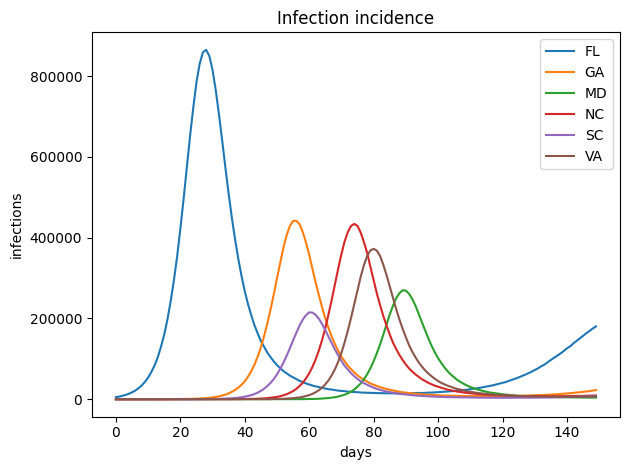

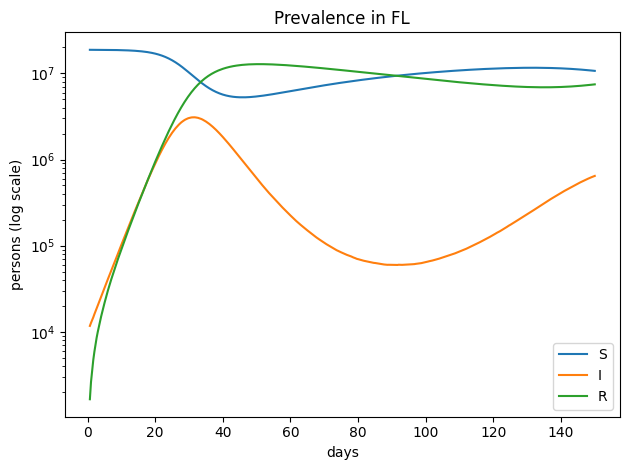

In [12]:
## Run the model and graph the outputs
sparsemod_ruminate(plot_results= True)